In [1]:
import os
import torch
import random
import cv2 as cv
import numpy as np
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

Skin detection code

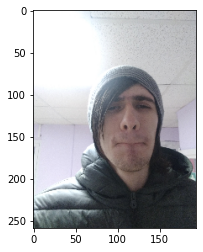

128


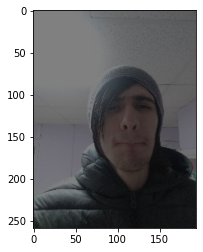

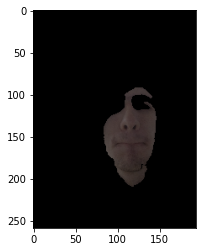

In [11]:
img = cv.cvtColor(cv.imread('Test15.jpg', cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)
img = cv.resize(img, None, fx = 0.1, fy = 0.1, interpolation = cv.INTER_CUBIC)
plt.imshow(img)
plt.show()

img[:, :, 0] = cv.multiply(img[:, :, 0], 0.5) #Brightness correction
img[:, :, 1] = cv.multiply(img[:, :, 1], 0.5)
img[:, :, 2] = cv.multiply(img[:, :, 2], 0.5)

print(img[0, 0, 0])

plt.imshow(img)
plt.show()

min_YCrCb = np.array([0, 133, 77], np.uint8) # Skin colors intervals
max_YCrCb = np.array([235, 173, 127], np.uint8) # borrowed from https://nalinc.github.io/blog/2018/skin-detection-python-opencv/

imageYCrCb = cv.cvtColor(img, cv.COLOR_RGB2YCR_CB)
skinRegionYCrCb = cv.inRange(imageYCrCb, min_YCrCb, max_YCrCb)

skinRegionYCrCb = cv.medianBlur(skinRegionYCrCb, 5) # Median filter

skinYCrCb = cv.bitwise_and(img, img, mask = skinRegionYCrCb)

plt.imshow(skinYCrCb)
plt.show()

Morphological operations and CCL method over detected skin

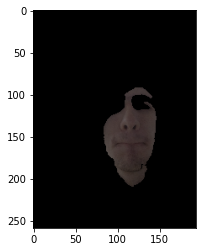

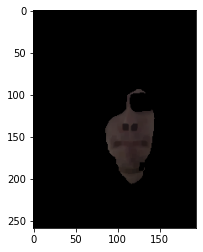

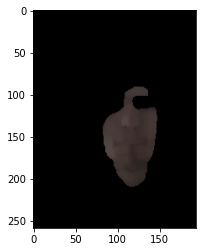

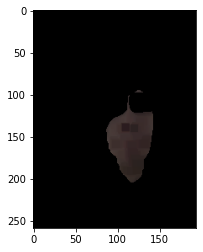

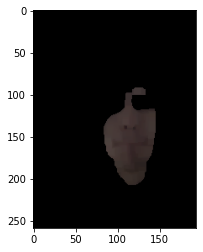

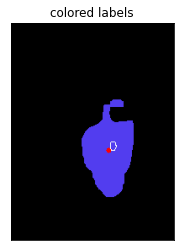

In [12]:
kernel = np.ones((3, 3), np.uint8)

erosion_1 = cv.erode(skinYCrCb, kernel, iterations = 2)
dilation_1 = cv.dilate(erosion_1, kernel, iterations = 3)
erosion_2 = cv.erode(dilation_1, kernel, iterations = 4)
dilation_2 = cv.dilate(erosion_2, kernel, iterations = 3)

plt.imshow(skinYCrCb)
plt.show()
plt.imshow(erosion_1)
plt.show()
plt.imshow(dilation_1)
plt.show()
plt.imshow(erosion_2)
plt.show()
plt.imshow(dilation_2)
plt.show()

def generate_colors(num):
    r = lambda: np.random.randint(0,255)
    return [(r(),r(),r()) for _ in range(num)]

dlt_2 = cv.cvtColor(dilation_2, cv.COLOR_RGB2GRAY)

connectivity = 8

n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(dlt_2, connectivity, cv.CV_32S)

colors = generate_colors(n_labels)

labeled_image = np.zeros((dilation_2.shape[0], dilation_2.shape[1], 3), dtype = np.uint8)

for (i, label) in enumerate(range(1, n_labels)):
    labeled_image[labels == label, :] = colors[i]
    
    cent_x, cent_y = int(centroids[label, 0]), int(centroids[label, 1])
    cv.circle(labeled_image, (cent_x, cent_y), 3, (255, 0, 0), -1)
    cv.putText(labeled_image, str(i), (cent_x, cent_y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

plt.title('colored labels')
plt.xticks([]), plt.yticks([])
plt.imshow(labeled_image)
plt.show()

The same without median filter

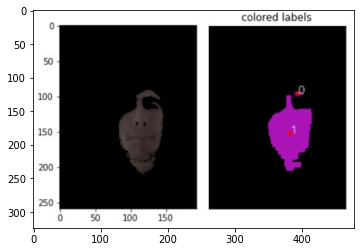

The same for high-resolution images

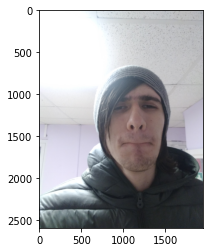

128


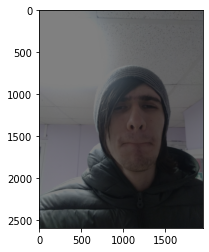

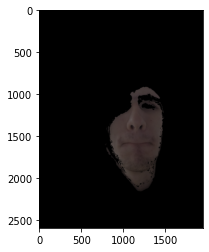

In [16]:
img = cv.cvtColor(cv.imread('Test15.jpg', cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)
f_img = img.copy()

plt.imshow(img)
plt.show()

img[:, :, 0] = cv.multiply(img[:, :, 0], 0.5)
img[:, :, 1] = cv.multiply(img[:, :, 1], 0.5)
img[:, :, 2] = cv.multiply(img[:, :, 2], 0.5)

print(img[0, 0, 0])

plt.imshow(img)
plt.show()

min_YCrCb1 = np.array([0, 133, 77], np.uint8) # Dark skin interval improvement
max_YCrCb1 = np.array([235, 173, 127], np.uint8)

min_YCrCb2 = np.array([20, 129, 117], np.uint8)
max_YCrCb2 = np.array([40, 143, 127], np.uint8)

imageYCrCb = cv.cvtColor(img, cv.COLOR_RGB2YCR_CB)
skinRegionYCrCb1 = cv.inRange(imageYCrCb, min_YCrCb1, max_YCrCb1)
skinRegionYCrCb2 = cv.inRange(imageYCrCb, min_YCrCb2, max_YCrCb2)

skinRegionYCrCb1 = cv.medianBlur(skinRegionYCrCb1, 5)
skinRegionYCrCb2 = cv.medianBlur(skinRegionYCrCb2, 5)

skinRegionYCrCb = skinRegionYCrCb1 + skinRegionYCrCb2
skinYCrCb = cv.bitwise_and(img, img, mask = skinRegionYCrCb)
skinYCrCb = cv.blur(skinYCrCb, (5, 5))

plt.imshow(skinYCrCb)
plt.show()

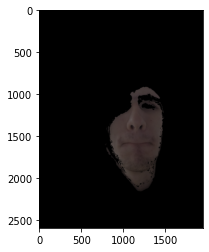

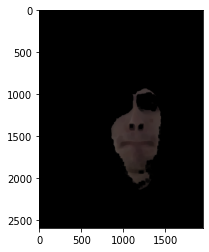

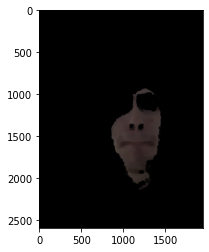

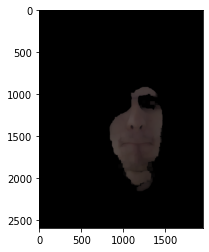

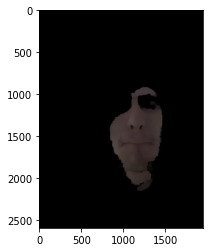

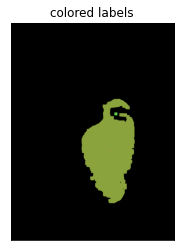

In [17]:
kernel = np.ones((5, 5), np.uint8)

erosion_1 = cv.erode(skinYCrCb, kernel, iterations = 8)
erosion = cv.medianBlur(erosion_1, 5) # Extra median blur
dilation_1 = cv.dilate(erosion, kernel, iterations = 9)
erosion_2 = cv.erode(dilation_1, kernel, iterations = 1)
dilation_2 = erosion_2

plt.imshow(skinYCrCb)
plt.show()
plt.imshow(erosion_1)
plt.show()
plt.imshow(erosion)
plt.show()
plt.imshow(dilation_1)
plt.show()
plt.imshow(dilation_2)
plt.show()

def generate_colors(num):
    r = lambda: np.random.randint(0,255)
    return [(r(),r(),r()) for _ in range(num)]

dlt_2 = cv.cvtColor(dilation_2, cv.COLOR_RGB2GRAY)

connectivity = 8

n_labels, labels, stats, centroids = cv.connectedComponentsWithStats(dlt_2, connectivity, cv.CV_32S)

colors = generate_colors(n_labels)

labeled_image = np.zeros((dilation_2.shape[0], dilation_2.shape[1], 3), dtype = np.uint8)

for (i, label) in enumerate(range(1, n_labels)):
    labeled_image[labels == label, :] = colors[i]
    
    cent_x, cent_y = int(centroids[label, 0]), int(centroids[label, 1])
    cv.circle(labeled_image, (cent_x, cent_y), 3, (255, 0, 0), -1)
    cv.putText(labeled_image, str(i), (cent_x, cent_y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

plt.title('colored labels')
plt.xticks([]), plt.yticks([])
plt.imshow(labeled_image)
plt.show()

Found intervals marking

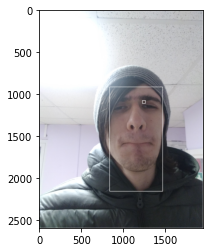

In [18]:
for i in range(label + 1):
    x = int(stats[i, cv.CC_STAT_TOP] * f_img.shape[0] / img.shape[0])
    y = int(stats[i, cv.CC_STAT_LEFT] * f_img.shape[1] / img.shape[1])
    h = int(stats[i, cv.CC_STAT_HEIGHT] * f_img.shape[0] / img.shape[0])
    w = int(stats[i, cv.CC_STAT_WIDTH] * f_img.shape[1] / img.shape[1])
    
    cv.rectangle(f_img, (y, x), (y + w, x + h), color = (255, 255, 255), thickness = 3)

plt.imshow(f_img)
plt.show()

Import of learning dataset for face detecting CNN

In [19]:
face = []
n_fc = []

for i in os.listdir('face detection/face'):
    face.append([cv.cvtColor(cv.imread('face detection/face/{}'.format(i), cv.IMREAD_COLOR), cv.COLOR_BGR2RGB), 1])

for i in os.listdir('face detection/non-face'):
    n_fc.append([cv.cvtColor(cv.imread('face detection/non-face/{}'.format(i), cv.IMREAD_COLOR), cv.COLOR_BGR2RGB), 0])

face = np.array(face)
n_fc = np.array(n_fc)

f_trn, f_tst = train_test_split(face, test_size = 0.2)
n_trn, n_tst = train_test_split(n_fc, test_size = 0.2)

train = []
test = []

for i in range(len(f_trn)):
    train.append(f_trn[i])
    train.append(n_trn[i])

for i in range(len(f_tst)):
    test.append(f_tst[i])
    test.append(n_tst[i])

random.shuffle(train)
random.shuffle(test)

train = np.array(train)
test = np.array(test)

trn_d = []
tst_d = []

trn_l = np.zeros(len(train))
tst_l = np.zeros(len(test))

for i in range(len(train)):
    trn_l[i] = train[i, 1]
    trn_d.append(train[i, 0])

for i in range(len(test)):
    tst_l[i] = test[i, 1]
    tst_d.append(test[i, 0])

trn_d = np.array(trn_d)
tst_d = np.array(tst_d)

C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


Structure of face detecting CNN

In [27]:
dtct_mdl = Sequential()

dtct_mdl.add(Conv2D(64, 3, activation = 'relu', input_shape = (48, 48, 3), padding = "same"))
dtct_mdl.add(MaxPooling2D(2, 2))

dtct_mdl.add(Conv2D(128, 3, activation = 'relu', padding = "same"))
dtct_mdl.add(MaxPooling2D(2, 2))

dtct_mdl.add(Conv2D(256, 3, activation = 'relu', padding = "same"))

dtct_mdl.add(Flatten())
dtct_mdl.add(Dense(1, activation = 'sigmoid'))

dtct_mdl.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Learning of face detecting CNN

In [28]:
dtct_mdl.fit(trn_d, trn_l, epochs = 7, batch_size = 20, validation_data = (tst_d, tst_l))

Train on 320 samples, validate on 80 samples
Epoch 1/7
320/320 [==============================] - 7s 21ms/sample - loss: 10.8446 - accuracy: 0.6125 - val_loss: 0.4791 - val_accuracy: 0.8000
Epoch 2/7
320/320 [==============================] - 6s 18ms/sample - loss: 0.3083 - accuracy: 0.8781 - val_loss: 0.2093 - val_accuracy: 0.9250
Epoch 3/7
320/320 [==============================] - 6s 19ms/sample - loss: 0.1242 - accuracy: 0.9656 - val_loss: 0.2018 - val_accuracy: 0.8750
Epoch 4/7
320/320 [==============================] - 6s 18ms/sample - loss: 0.0658 - accuracy: 0.9844 - val_loss: 0.1859 - val_accuracy: 0.9250
Epoch 5/7
320/320 [==============================] - 5s 16ms/sample - loss: 0.0304 - accuracy: 0.9906 - val_loss: 0.1564 - val_accuracy: 0.9500
Epoch 6/7
320/320 [==============================] - 5s 17ms/sample - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.1963 - val_accuracy: 0.9500
Epoch 7/7
320/320 [==============================] - 6s 18ms/sample - loss: 0.0101 - accur

Build of a dataset of cropped images to detect face

In [29]:
chck_set = []

for i in range(label):
    x = int(stats[i + 1, cv.CC_STAT_TOP] * f_img.shape[0] / img.shape[0])
    y = int(stats[i + 1, cv.CC_STAT_LEFT] * f_img.shape[1] / img.shape[1])
    h = int(stats[i + 1, cv.CC_STAT_HEIGHT] * f_img.shape[0] / img.shape[0])
    w = int(stats[i + 1, cv.CC_STAT_WIDTH] * f_img.shape[1] / img.shape[1])
    
    chck_set.append(cv.resize(f_img[x : x + h, y : y + w], (48, 48), interpolation = cv.INTER_CUBIC))

chck_set = np.array(chck_set)

Face / non-face check

In [30]:
res = dtct_mdl.predict(chck_set)
print(res)

[[0.59093034]
 [0.67226934]]


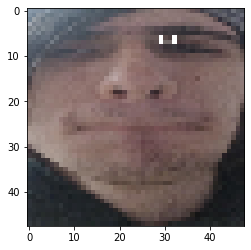

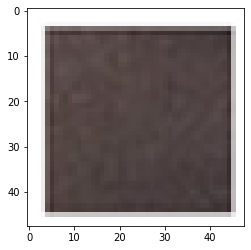

In [31]:
for i in chck_set:
    plt.imshow(i)
    plt.show()

Facial expression analysis (the training dataset is under improvement, therefore, the confusion matrix doesn't coincide with the one in the report)

In [32]:
data = []
path = 'face detection/emotions/'
func = np.array
nb = 255

for i, j, k, l, m, n, o in zip(os.listdir(path + 'angry'), os.listdir(path + 'disgust'), os.listdir(path + 'fear'), 
    os.listdir(path + 'happy'), os.listdir(path + 'neutral'), os.listdir(path + 'sad'), os.listdir(path + 'surprise')):
    data.append([cv.imread('face detection/emotions/angry/{}'.format(i), cv.IMREAD_COLOR) / nb, func([1, 0, 0, 0, 0, 0, 0])])
    data.append([cv.imread('face detection/emotions/disgust/{}'.format(j), cv.IMREAD_COLOR) / nb, func([0, 1, 0, 0, 0, 0, 0])])
    data.append([cv.imread('face detection/emotions/fear/{}'.format(k), cv.IMREAD_COLOR) / nb, func([0, 0, 1, 0, 0, 0, 0])])
    data.append([cv.imread('face detection/emotions/happy/{}'.format(l), cv.IMREAD_COLOR) / nb, func([0, 0, 0, 1, 0, 0, 0])])
    data.append([cv.imread('face detection/emotions/neutral/{}'.format(m), cv.IMREAD_COLOR) / nb, func([0, 0, 0, 0, 1, 0, 0])])
    data.append([cv.imread('face detection/emotions/sad/{}'.format(n), cv.IMREAD_COLOR) / nb, func([0, 0, 0, 0, 0, 1, 0])])
    data.append([cv.imread('face detection/emotions/surprise/{}'.format(o), cv.IMREAD_COLOR) / nb, func([0, 0, 0, 0, 0, 0, 1])])

random.shuffle(data)
data = np.array(data)
trn, tst = train_test_split(data, test_size = 0.2)

tr_dt = []
ts_dt = []

tr_lb = []
ts_lb = []

for i in range(len(trn)):
    tr_dt.append(trn[i, 0])
    tr_lb.append(trn[i, 1])

for i in range(len(tst)):
    ts_dt.append(tst[i, 0])
    ts_lb.append(tst[i, 1])

tr_dt = np.array(tr_dt)
ts_dt = np.array(ts_dt)
tr_lb = np.array(tr_lb)
ts_lb = np.array(ts_lb)

C:\Users\72684\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


The facial expression analysis CNN structure

In [33]:
anlz_mdl = Sequential()

anlz_mdl.add(Conv2D(64, 3, activation = 'relu', input_shape = (48, 48, 3), padding = "same"))
anlz_mdl.add(MaxPooling2D(2, 2))

anlz_mdl.add(Conv2D(128, 3, activation = 'relu', padding = "same"))
anlz_mdl.add(MaxPooling2D(2, 2))

anlz_mdl.add(Conv2D(256, 3, activation = 'relu', padding = "same"))
anlz_mdl.add(MaxPooling2D(2, 2))

anlz_mdl.add(Conv2D(512, 3, activation = 'relu', padding = "same"))
anlz_mdl.add(MaxPooling2D(2, 2))

anlz_mdl.add(Flatten())
anlz_mdl.add(Dense(500, activation = 'sigmoid'))
anlz_mdl.add(Dense(7, activation = 'softmax'))

anlz_mdl.compile(loss = 'categorical_crossentropy', optimizer = 'Adagrad', metrics = ['CategoricalAccuracy'])

Facial expressions analysis CNN learning

In [35]:
anlz_mdl.fit(tr_dt, tr_lb, epochs = 15, batch_size = 35, validation_data = (ts_dt, ts_lb))

Train on 252 samples, validate on 63 samples
Epoch 1/15
252/252 [==============================] - 7s 29ms/sample - loss: 2.0331 - CategoricalAccuracy: 0.1468 - val_loss: 2.0209 - val_CategoricalAccuracy: 0.1111
Epoch 2/15
252/252 [==============================] - 6s 23ms/sample - loss: 1.9699 - CategoricalAccuracy: 0.1310 - val_loss: 1.9729 - val_CategoricalAccuracy: 0.1270
Epoch 3/15
252/252 [==============================] - 5s 22ms/sample - loss: 1.9469 - CategoricalAccuracy: 0.1349 - val_loss: 1.9597 - val_CategoricalAccuracy: 0.0952
Epoch 4/15
252/252 [==============================] - 6s 25ms/sample - loss: 1.9284 - CategoricalAccuracy: 0.1667 - val_loss: 1.9669 - val_CategoricalAccuracy: 0.0952
Epoch 5/15
252/252 [==============================] - 6s 24ms/sample - loss: 1.9068 - CategoricalAccuracy: 0.2143 - val_loss: 2.0733 - val_CategoricalAccuracy: 0.0952
Epoch 6/15
252/252 [==============================] - 6s 25ms/sample - loss: 1.8540 - CategoricalAccuracy: 0.2659 - val_

Results visualization

Precision: 0.7142857142857143


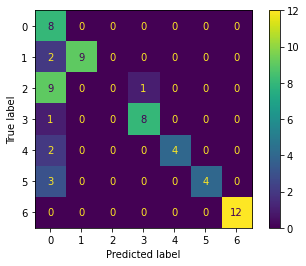

In [37]:
rst = anlz_mdl.predict(ts_dt)
ttl = 0

for i in range(len(ts_lb)):
    if np.argmax(rst[i]) == np.argmax(ts_lb[i]):
        ttl += 1

print('Precision: ' + str(ttl / len(ts_lb)))

matrix = metrics.confusion_matrix(np.argmax(ts_lb, axis = 1), np.argmax(rst, axis = 1))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = list(set(np.argmax(ts_lb, axis = 1))))
disp.plot()
plt.show()

0 - angry

1 - disgust

2 - fear

3 - happy

4 - neutral

5 - sad

6 - surprise

Detected regions check

In [38]:
for i in range(len(chck_set)):
    chck_set[i] = cv.cvtColor(cv.cvtColor(chck_set[i], cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB) # Learning dara is grayscale

rst = anlz_mdl.predict(chck_set)
print(np.argmax(rst, axis = 1))

[1 1]


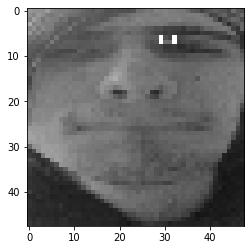

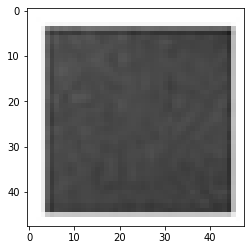

In [39]:
for i in chck_set:
    plt.imshow(i)
    plt.show()